# Arctangents
> Something is wrong with the way candidates are computed. What is it?

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hyperdt.toy_data import wrapped_normal_mixture
from hyperdt.hyperbolic_trig import get_midpoint, get_candidates_hyperbolic
from hyperdt.tree import HyperbolicDecisionTreeClassifier

INFO: Using numpy backend


Text(0, 0.5, 'Timelike')

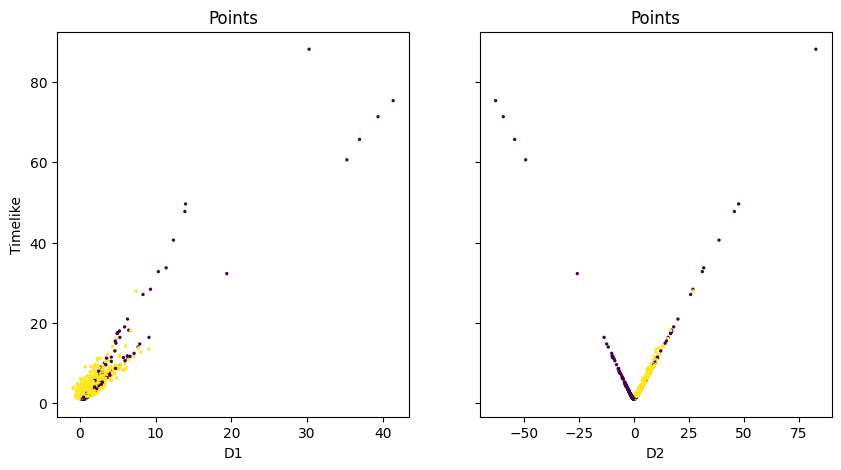

In [11]:
# Draw points, plot both dimensions:
points, labels = wrapped_normal_mixture(num_points=1000, num_classes=2, seed=42)

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
axs[0].scatter(points[:, 1], points[:, 0], c=labels, s=2)
axs[0].set_title("Points")
axs[0].set_xlabel("D1")

axs[1].scatter(points[:, 2], points[:, 0], c=labels, s=2)
axs[1].set_title("Points")
axs[1].set_xlabel("D2")
axs[0].set_ylabel("Timelike")

2.6813198172881414e-07 1.6162464337998728e-06


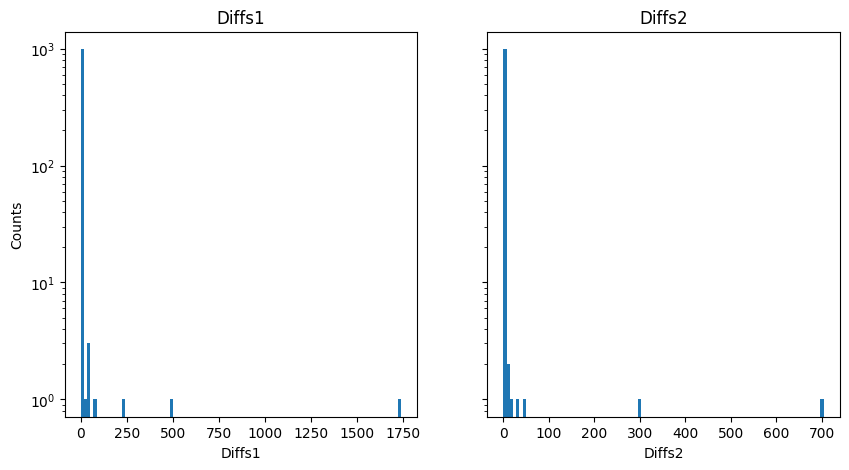

In [12]:
# Are any of the points collinear?


def check_collinear_dim(points, dim):
    """Checks if any points are collinear in (0, dim) subplane."""
    y = points[:, 0]
    x = points[:, dim]
    ratios = y / x
    # ratios = np.log(y) - np.log(x)
    sorted_ratios = np.sort(ratios)
    return np.diff(sorted_ratios, n=1)


# Seems like some of these values can be quite low:
diffs1 = check_collinear_dim(points, 1)
diffs2 = check_collinear_dim(points, 2)
print(diffs1.min(), diffs2.min())

# Let's look at a histogram of diffs
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
axs[0].hist(diffs1, bins=100)
axs[0].set_title("Diffs1")
axs[0].set_xlabel("Diffs1")
axs[1].hist(diffs2, bins=100)
axs[1].set_title("Diffs2")
axs[1].set_xlabel("Diffs2")
axs[0].set_ylabel("Counts")
plt.yscale("log")
plt.show()

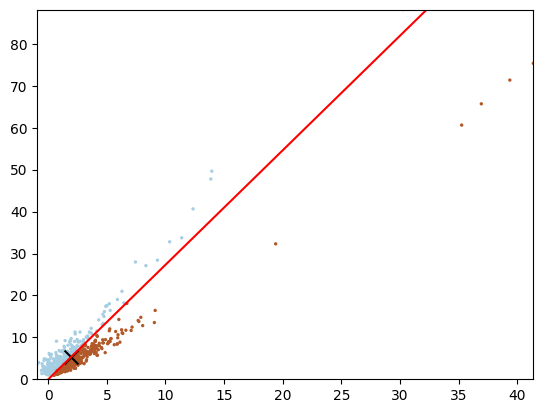

In [86]:
# Can we get the points to move along with this?


def normal(dim, theta):
    v = np.zeros(3)
    a = np.sqrt(-1 / np.cos(2 * theta))  # sqrt(-sec(2 theta))
    v[dim] = np.sin(theta) * a
    v[0] = -np.cos(theta) * a
    return v


def plot_normal(points, dim, theta, idx=None, product="sparse_dot"):
    # Special index code: find theta based on idx
    if idx is not None:
        theta = np.arctan(points[idx, 0] / points[idx, dim])

    # Plot points
    v = normal(dim, theta)
    if product == "sparse_dot":
        classes = np.sign(np.sin(theta) * points[:, dim] - np.cos(theta) * points[:, 0])
    elif product == "dense_dot":
        classes = np.sign(points @ v)
    elif product == "sparse_minkowski":
        classes = np.sign(np.sin(theta) * points[:, dim] + np.cos(theta) * points[:, 0])
    else:
        raise ValueError("Invalid product")
    plt.scatter(points[:, dim], points[:, 0], s=2, c=classes, cmap="Paired")

    # Plot separating line
    min_x = np.min(points[:, dim])
    max_x = np.max(points[:, dim])
    if product == "sparse_minkowski":
        plt.plot([-1000 * np.cos(theta), 1000 * np.cos(theta)], [1000 * np.sin(theta), -1000 * np.sin(theta)], c="red")
    else:
        plt.plot([-1000 * np.cos(theta), 1000 * np.cos(theta)], [-1000 * np.sin(theta), 1000 * np.sin(theta)], c="red")

    # Fix axis limits
    plt.ylim(0, points[:, 0].max())
    plt.xlim(points[:, dim].min(), points[:, dim].max())

    if idx is not None:
        plt.scatter(points[idx, dim], points[idx, 0], s=100, c="black", marker="x")


# plot_normal(points, 1, np.pi / 4 + .01)
# plot_normal(points, 1, 3 * np.pi / 4 - .01)
plot_normal(points, 1, np.pi / 4 + 0.3, idx=12, product="sparse_dot")

# Here is our system:
# theta = tan^-1(timelike / spacelike)
# This theta tells us how far we incline our hyperplane relative to x0 = 0
# blue = negative sign, brown = positive sign
# pi / 4 = right side (all left of red line = all blue)
# 3pi / 4 = left side (all right of red line = all brown)

# Then, our normal vectors must be
# a * <-cos(theta), ..., sin(theta), ... >
# that means our (sparse) dot-product is:
# sin(theta) * x1 - cos(theta) * x0

0


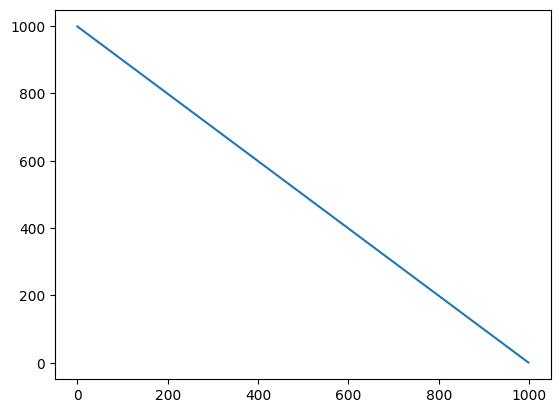

In [71]:
# Sanity check theta candidates: should be smooth!

thetas = sorted(np.arctan2(points[:, 0], points[:, 1]))
midpoints = [get_midpoint(t1, t2) for t1, t2 in zip(thetas[:-1], thetas[1:])]


def sanity_check(thetas):
    n_negs = []
    n_aberrations = 0
    for theta in thetas:
        classes = np.sign(np.sin(theta) * points[:, 1] - np.cos(theta) * points[:, 0])
        new_n_negs = np.sum(classes == -1)
        if n_negs and new_n_negs != n_negs[-1] - 1:
            n_aberrations += 1
        n_negs.append(new_n_negs)

    print(n_aberrations)
    plt.plot(n_negs)
    plt.show()


sanity_check(midpoints)

0


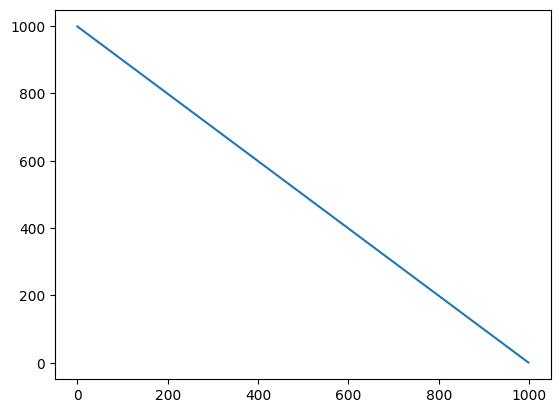

In [62]:
# Same sanity check, using get_candidates_hyperbolic

sanity_check(get_candidates_hyperbolic(X=points, dim=1, timelike_dim=0))

0


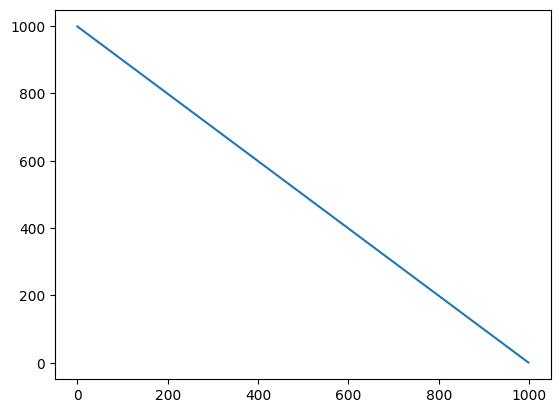

In [63]:
# Same sanity check, using dot products as defined in hdt

hdt = HyperbolicDecisionTreeClassifier()
midpoints = get_candidates_hyperbolic(X=points, dim=1, timelike_dim=0)
n_negs = []
n_aberrations = 0
for theta in midpoints:
    classes = np.sign(hdt._dot(points, 1, theta))
    new_n_negs = np.sum(classes == -1)
    if n_negs and new_n_negs != n_negs[-1] - 1:
        n_aberrations += 1
    n_negs.append(new_n_negs)

print(n_aberrations)
plt.plot(n_negs)
plt.show()

2


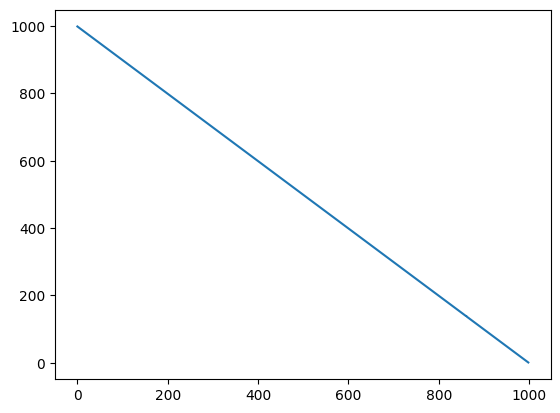

In [89]:
# Check minkowski quickly

# Same sanity check, using dot products as defined in hdt
hdt = HyperbolicDecisionTreeClassifier(dot_product="sparse_minkowski")
midpoints = hdt._get_candidates(X=points, dim=1)
n_negs = []
n_aberrations = 0
for theta in midpoints:
    classes = np.sign(hdt._dot(points, 1, theta))
    new_n_negs = np.sum(classes == -1)
    if n_negs and new_n_negs != n_negs[-1] - 1:
        n_aberrations += 1
    n_negs.append(new_n_negs)

print(n_aberrations)
plt.plot(n_negs)
plt.show()

In [64]:
# Great, so it looks like all of these methods effectively allow us to scoot
# along the manifold, moving one point at a time between classes. This is all we need
# to have a good decision tree!

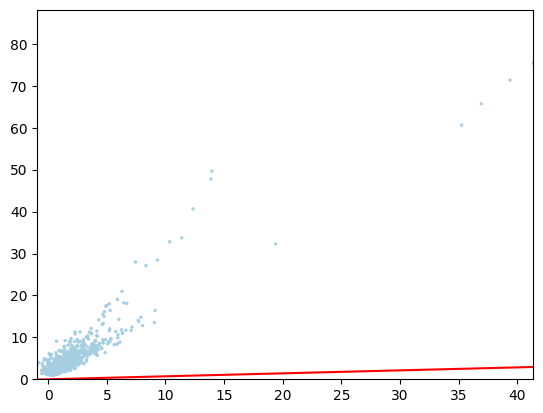

In [87]:
plot_normal(points, 1, np.pi - 1.5, product="sparse_minkowski")